In [28]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Improving Olist's Estimated Delivery Time (ETA)

👉 `Estimated Time of Arrival (ETA)` is a key component of modern e-commerce services. It allows companies to manage customer expectations by showing a predicted date for customer delivery.

🎯 In this challenge, we will build a predictive model that `estimates the wait time` of an order.

☑️ Olist already has its own predictions under the variable `expected_wait_time`

🚀 Let's challenge ourselves to do better predictions and at the end of this recap, 
we will compare:
* our `estimated_wait_time`
* Olist's `expected_wait_time`
* the real `wait_time` for each order delivered

## Load and check `orders` dataset

👉 `Order().get_training_data()` (include `distance_seller_customer`)

In [29]:
from olist.order import Order
orders = Order().get_training_data(with_distance_seller_customer=True)

In [30]:
orders.head(3)

,order_id,wait_time,expected_wait_time,delay_vs_expected,order_status,dim_is_five_star,dim_is_one_star,review_score,number_of_products,number_of_sellers,price,freight_value,distance_seller_customer
0,e481f51cbdc54678b7cc49136f2d6af7,8.436574,15.544063,0.0,delivered,0,0,4,1,1,29.99,8.72,18.063837
1,53cdb2fc8bc7dce0b6741e2150273451,13.782037,19.137766,0.0,delivered,0,0,4,1,1,118.70,22.76,856.292580
2,47770eb9100c2d0c44946d9cf07ec65d,9.394213,26.639711,0.0,delivered,1,0,5,1,1,159.90,19.22,514.130333


In [31]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95872 entries, 0 to 95879
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   order_id                  95872 non-null  object 
 1   wait_time                 95872 non-null  float64
 2   expected_wait_time        95872 non-null  float64
 3   delay_vs_expected         95872 non-null  float64
 4   order_status              95872 non-null  object 
 5   dim_is_five_star          95872 non-null  int64  
 6   dim_is_one_star           95872 non-null  int64  
 7   review_score              95872 non-null  int64  
 8   number_of_products        95872 non-null  int64  
 9   number_of_sellers         95872 non-null  int64  
 10  price                     95872 non-null  float64
 11  freight_value             95872 non-null  float64
 12  distance_seller_customer  95872 non-null  float64
dtypes: float64(6), int64(5), object(2)
memory usage: 10.2+ MB


## Baseline Model - Olist’s current ETA model

🐣  What's the baseline we want to optimize ❓

👉 The delta between Olist' `expected_wait_time` and the real `wait_time`

📈 Plot their respective histograms

<AxesSubplot:xlabel='wait_time', ylabel='Density'>

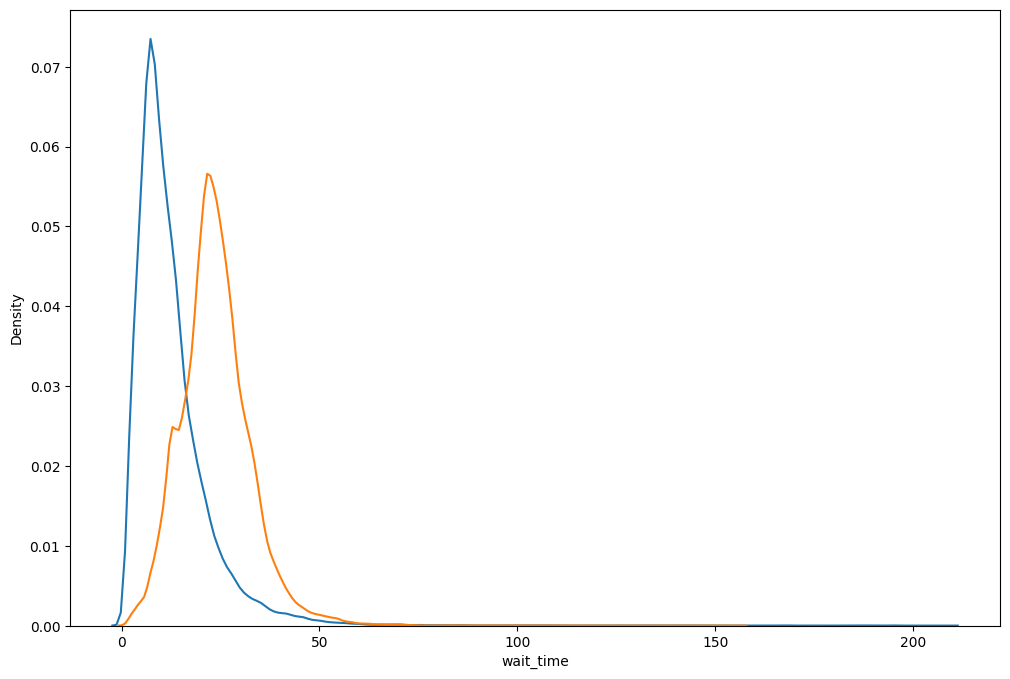

In [32]:
plt.figure(figsize=(12, 8))
sns.kdeplot(orders['wait_time'], label='wait_time')
sns.kdeplot(orders['expected_wait_time'], label='expected_wait_time')

👉 What is the median wait time ? the median expected wait time ? 

In [33]:
orders[['wait_time', 'expected_wait_time']].median()

wait_time             10.203727
expected_wait_time    23.230556
dtype: float64

👉 Compute the baseline RMSE 

ℹ️ The errors considered here are the misapproximations from Olist in terms of waiting time.

In [34]:
olist_error = orders['wait_time'] - orders['expected_wait_time']
RMSE = (np.mean(olist_error**2))**0.5
RMSE

15.110701386210625

## OLS multivariate model

👉 We will create an OLS model using the `statsmodel.api.OLS` method this time.

(instead of `statsmodel.formula.api.ols`) 

### Prepare the dataset with the  features X and the target Y

In [35]:
Y = orders['wait_time'].copy()

X = orders[[
    'expected_wait_time',
    'number_of_products',
    'price',
    'freight_value',
    'distance_seller_customer'
]].copy()
X.shape

(95872, 5)

⚖️ Standardize (`z-score`) each feature of X to compare regression coefficients that will result from the OLS:

In [36]:
X_std = X.copy()

for i in X_std.columns:
    X_std[i] = (X_std[i] - X_std[i].mean()) / X_std[i].std()

In [37]:
# Check how different is it from the "formula" in statsmodel
import patsy
patsy.dmatrix('price + distance_seller_customer', orders)

DesignMatrix with shape (95872, 3)
  Intercept   price  distance_seller_customer
          1   29.99                  18.06384
          1  118.70                 856.29258
          1  159.90                 514.13033
          1   45.00                1822.80037
          1   19.90                  30.17404
          1  147.90                 411.95300
          1   59.99                 321.73040
          1   19.90                 872.66930
          1  149.99                 111.51773
          1  198.00                 413.25219
          1   98.00                 844.97722
          1   31.90                 452.20571
          1   19.90                 308.45551
          1   38.25                 430.59899
          1  132.40                 161.60460
          1   27.99                 547.73905
          1   17.90                 209.39770
          1   76.00                1434.17366
          1  109.90                  11.84639
          1   79.99                  19.27366

⚠️ With this `statsmodel.api.OLS`, we always need to add a constant "intercept" to the features dataset:

In [38]:
X_std['constant'] = 1
X_std.head()

,expected_wait_time,number_of_products,price,freight_value,distance_seller_customer,constant
0,-0.934806,-0.264595,-0.513802,-0.652038,-0.979475,1
1,-0.524871,-0.264595,-0.086640,0.000467,0.429743,1
2,0.330878,-0.264595,0.111748,-0.164053,-0.145495,1
3,0.279445,-0.264595,-0.441525,0.206815,2.054621,1
4,-1.326297,-0.264595,-0.562388,-0.652038,-0.959115,1


### Run OLS with `statsmodels` and print `summary`

In [39]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

model = sm.OLS(Y, X_std).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              wait_time   R-squared:                       0.203
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     4892.
Date:                Wed, 08 Nov 2023   Prob (F-statistic):               0.00
Time:                        17:47:56   Log-Likelihood:            -3.4052e+05
No. Observations:               95872   AIC:                         6.811e+05
Df Residuals:                   95866   BIC:                         6.811e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
expected_wait_time           2.3135      0.032     72.486      0.000       2.251       2.376
number_of_products          -0.3716      0.031    -12.040      0.000      -0.432      -0.311
price                        0.0433      0.030      1.446      0.148      -0.015       0.102
freight_value                0.4187      0.035     11.870      0.000       0.350       0.488
distance_seller_customer     2.4049      0.033     72.697      0.000       2.340       2.470
constant                    12.5134      0.027    459.091      0.000      12.460      12.567
==============================================================================
Omnibus:                    94636.478   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         12188284.275
Skew:                           4.537   Prob(JB):                         0.00
Kurtosis:                      57.487   Cond. No.                         2.24
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Check the performance of your OLS model

### Goodness of fit

👉 Who has the best predictions, you or Olist ? 

- Compute your predictions and store them in `y_pred`

- You can store :
    - Olist's predictions in a `y_expected_olist` variable
    - the real waiting times in a `y_true` variable



In [40]:
y_true = orders['wait_time']
y_expected_olist = orders['expected_wait_time']
y_pred = model.predict(X_std)

📈 Plot `y_pred`, `y_expected_olist` and `y_true` on the same graph.

<function matplotlib.pyplot.legend(*args, **kwargs)>

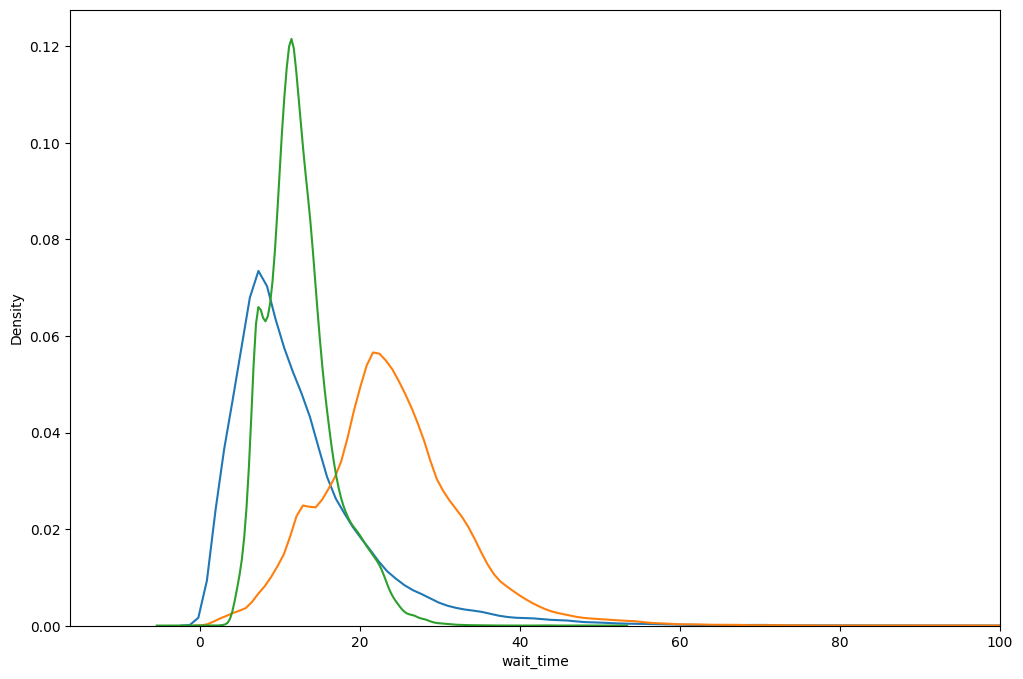

In [41]:
plt.figure(figsize=(12, 8))
sns.kdeplot(y_true, label='true')
sns.kdeplot(y_expected_olist, label='expected')
sns.kdeplot(y_pred, label='y_pred')
plt.xlim(xmax=100)
plt.legend

👉 Compute the RMSE where the errors are now *your* errors !

In [42]:
residuals_lewagon = y_pred - y_true
RMSE_lewagon = (residuals_lewagon**2).mean()**0.5
RMSE_lewagon

8.439369169659281

Just as a reminder, Olist's RMSE was equal to : 👇

**baseline_RMSE**

😏 Did we really beat Olist's Data Scientists ? We cannot really say that!

- In many e-commerce and delivery services, the ETA is often overestimated...
- When customers receive their orders earlier than expected, they are more likely to be satisfied !

### Partial correlations

👉 Visualize partial correlations with `sm.graphics.plot_partregress_grid`

eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1


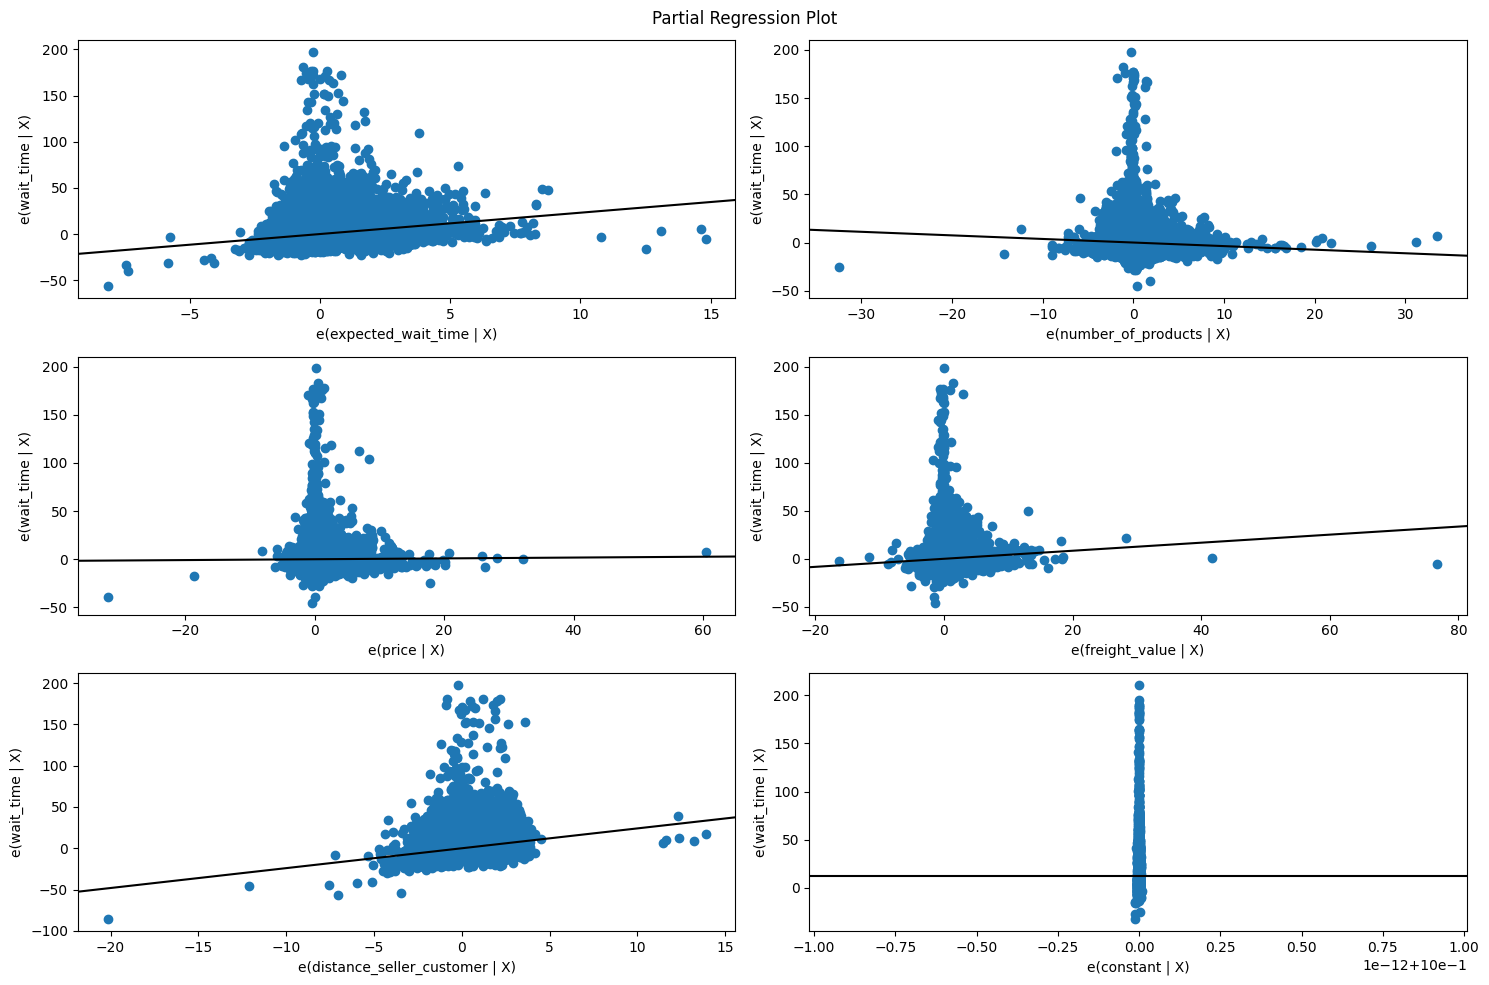

In [62]:
fig = plt.figure(figsize=(15,10))
sm.graphics.plot_partregress_grid(model, fig=fig)
plt.show()

**How do we read these graphs ?**

👉 Let's focus - for instance - on the graph in the bottom left corner:

<u>Partial regression of `wait_time` against `distance`</u>

- Each point is an order in our dataset


- `y-axis`: residuals of the `wait_time`, using all features except `distance`

    - These residuals contain the remaining information about `wait_time` that couldn't be explained without `distance`


- `x-axis`: residuals of predicting `distance` by using all other features (price, freight_value, etc...)
    - These residuals contain the new information that `distance` brings to the table, which is not already explained by the other features in the model.



### Inferential conditions

⚠️ Check you residuals. Are they normally distributed?

<AxesSubplot:ylabel='Density'>

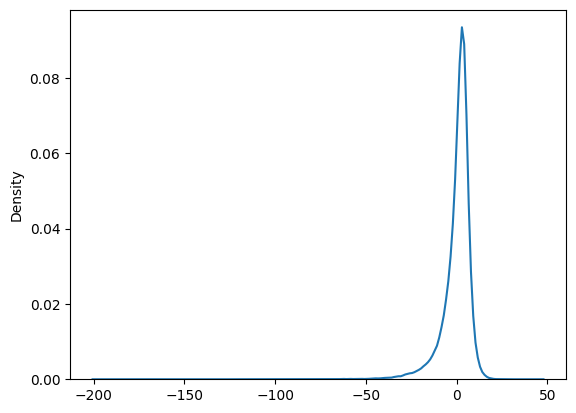

In [45]:
sns.kdeplot(residuals_lewagon)

🎁 A more precise way to visualize whether a distribution is Gaussian or not is the <a href="https://www.statsmodels.org/stable/generated/statsmodels.graphics.gofplots.qqplot.html">**`QQplot`**</a>. 

📈 Plot the QQplot of your residual below

💡 Make sure to understand the relation between the QQ plot and the density previsouly drawn..

📚 <a href="https://stats.stackexchange.com/questions/101274/how-to-interpret-a-qq-plot">Stats.StackExchange.com - Interpreting QQplots</a>

- `x-axis` : theoretical quantiles of a Gaussian distribution
- `y-axis`: quantiles of the sorted variable

💡 If the <span style="color:blue">blue</span> points are aligned on the <span style="color:red">red line</span> which is the identity function, the variable has a Gaussian distribution !

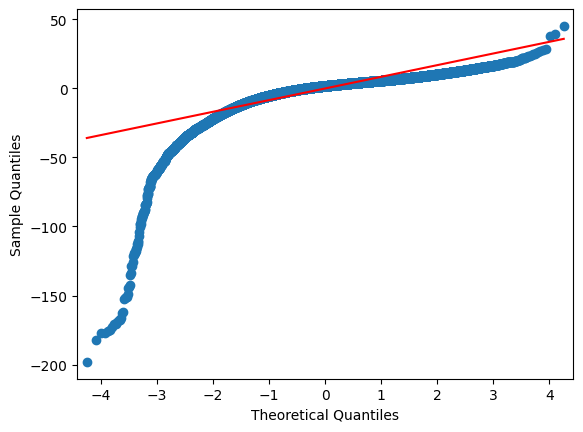

In [46]:
sm.qqplot(residuals_lewagon, line='s');

#### Some QQplot examples:

Run the cells below to understand how QQ plots are graphed:

In [47]:
from scipy import stats 
stats.norm.rvs(0,1)

0.06713317496903273

(-4.33877105230786, 10.0)

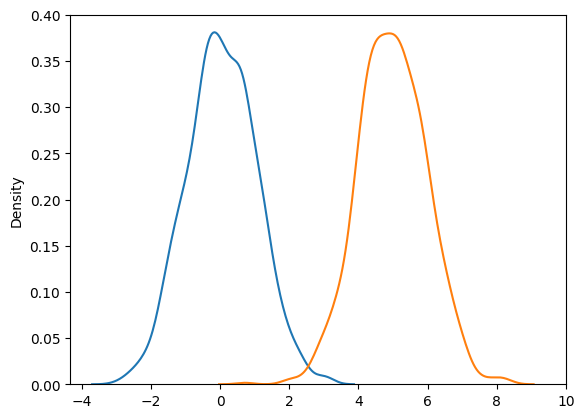

In [48]:
# lets check QQ plots with our own distributions
from scipy import stats

norm_1 = [stats.norm.rvs(0,1) for x in range(1000)]
norm_2 = [stats.norm.rvs(5,1) for x in range(1000)]

sns.kdeplot(norm_1)
sns.kdeplot(norm_2)
plt.xlim(right=10)

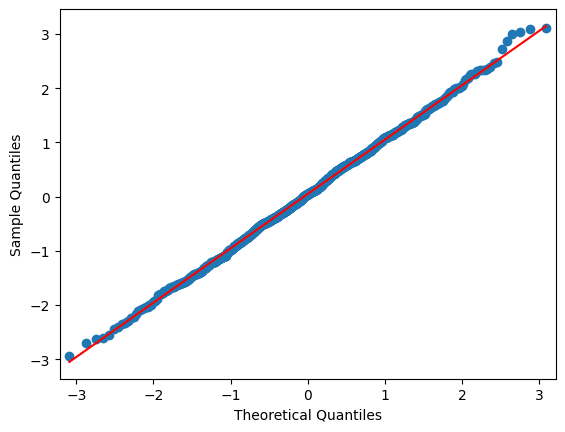

In [49]:
sm.qqplot(np.asarray(norm_1), line='s');

(-5.428307085305125, 10.0)

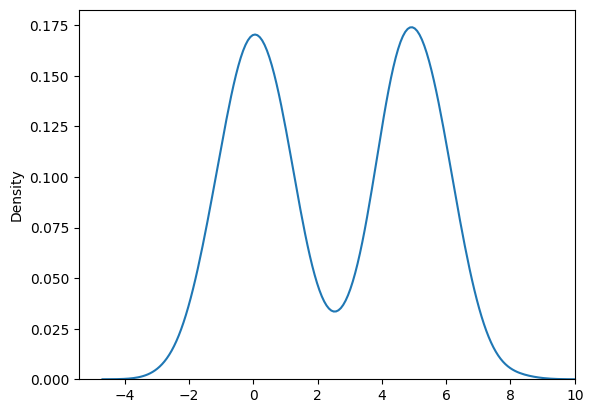

In [50]:
bimodal = norm_1 + norm_2
sns.kdeplot(bimodal)
plt.xlim(right=10)

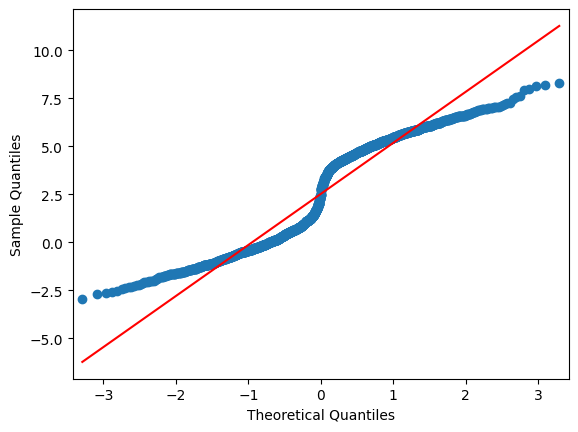

In [51]:
sm.qqplot(np.asarray(bimodal), line='s');

<img src="https://wagon-public-datasets.s3.amazonaws.com/04-Decision-Science/03-Linear-Regression/qq_plot_interpretation.png" width=400>

#### Check residuals vs. fitted to see if we can detect any non-random pattern

(0.0, 50.0)

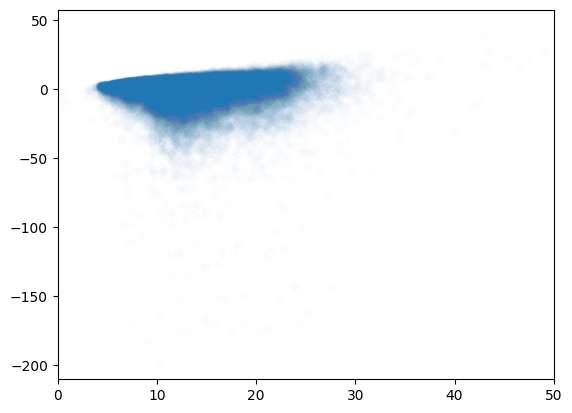

In [52]:
sns.scatterplot(x = y_pred, y = residuals_lewagon, alpha=0.01)
plt.xlim(xmin=0, xmax=50)

## More Features? (Optional)

Here we can add additional features from the product details (size, category etc..)

### Add product details associated with each order (sum of product sizes, sum of weights etc...)

In [53]:
from olist.data import Olist
data = Olist().get_data()
products = data['products']
order_items = data['order_items']

In [54]:
order_items_products = (
    order_items.groupby(["order_id", "product_id"], as_index=False)
    .agg({"order_item_id": "count"})
    .rename(columns={"order_item_id": "order_item_count"})
    .merge(products.drop(["product_category_name"], axis=1), on="product_id")
)
order_items_products

,order_id,product_id,order_item_count,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,1,58.0,598.0,4.0,650.0,28.0,9.0,14.0
1,130898c0987d1801452a8ed92a670612,4244733e06e7ecb4970a6e2683c13e61,1,58.0,598.0,4.0,650.0,28.0,9.0,14.0
2,532ed5e14e24ae1f0d735b91524b98b9,4244733e06e7ecb4970a6e2683c13e61,1,58.0,598.0,4.0,650.0,28.0,9.0,14.0
3,6f8c31653edb8c83e1a739408b5ff750,4244733e06e7ecb4970a6e2683c13e61,1,58.0,598.0,4.0,650.0,28.0,9.0,14.0
4,7d19f4ef4d04461989632411b7e588b9,4244733e06e7ecb4970a6e2683c13e61,1,58.0,598.0,4.0,650.0,28.0,9.0,14.0
...,...,...,...,...,...,...,...,...,...,...
102420,ffebd80e3291e811c308365936897efd,4cc4d02efc8f249c13355147fb44e34d,1,37.0,653.0,1.0,6700.0,35.0,12.0,22.0
102421,ffee31fb4b5e35c9123608015637c495,b10ecf8e33aaaea419a9fa860ea80fb5,1,30.0,308.0,1.0,2300.0,37.0,30.0,20.0
102422,fff7c4452f050315db1b3f24d9df5fcd,dd469c03ad67e201bc2179ef077dcd48,1,33.0,658.0,3.0,400.0,19.0,9.0,15.0
102423,fffa82886406ccf10c7b4e35c4ff2788,bbe7651fef80287a816ead73f065fc4b,1,32.0,280.0,2.0,2700.0,60.0,15.0,15.0


In [55]:
# Since we want the sum of product weights per order from our new DataFrame, we need to multiply weight by product count
order_items_products['product_weight_g'] = order_items_products['product_weight_g'] *  order_items_products['order_item_count']

order_items_features = order_items_products.groupby("order_id", as_index=False).agg(
    {
        "product_weight_g": "sum",
        "product_length_cm": "max",
        "product_height_cm": "max",
        "product_width_cm": "max",
    }).rename(columns={
        "product_weight_g": "product_weight_g_sum",
        "product_length_cm": "product_length_cm_max",
        "product_height_cm": "product_height_cm_max",
        "product_width_cm": "product_width_cm_max",
    })
order_items_features

,order_id,product_weight_g_sum,product_length_cm_max,product_height_cm_max,product_width_cm_max
0,00010242fe8c5a6d1ba2dd792cb16214,650.0,28.0,9.0,14.0
1,00018f77f2f0320c557190d7a144bdd3,30000.0,50.0,30.0,40.0
2,000229ec398224ef6ca0657da4fc703e,3050.0,33.0,13.0,33.0
3,00024acbcdf0a6daa1e931b038114c75,200.0,16.0,10.0,15.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,3750.0,35.0,40.0,30.0
...,...,...,...,...,...
98661,fffc94f6ce00a00581880bf54a75a037,10150.0,89.0,15.0,40.0
98662,fffcd46ef2263f404302a634eb57f7eb,8950.0,45.0,26.0,38.0
98663,fffce4705a9662cd70adb13d4a31832d,967.0,21.0,24.0,19.0
98664,fffe18544ffabc95dfada21779c9644f,100.0,20.0,20.0,20.0


In [56]:
orders_with_details = orders.merge(order_items_features, on="order_id", how="left").dropna()

In [57]:
X2 = orders_with_details[[
        "number_of_products",
        "number_of_sellers",
        "price",
        "freight_value",
        "distance_seller_customer",
        "product_weight_g_sum",
        "product_length_cm_max",
        "product_height_cm_max",
        "product_width_cm_max"]].copy()
y2 = orders_with_details["wait_time"].copy()

In [58]:
# standardize (z-normalize) each features of X to compare coefficients
for f in X2.columns:
    mu = X2[f].mean()
    sigma = X2[f].std()
    X2[f] = X2[f].map(lambda x: (x - mu) / sigma)

In [59]:
X2['constant'] = 1

In [60]:
model2 = sm.OLS(y2, X2).fit()

In [61]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              wait_time   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     2112.
Date:                Wed, 08 Nov 2023   Prob (F-statistic):               0.00
Time:                        18:00:31   Log-Likelihood:            -3.4269e+05
No. Observations:               95856   AIC:                         6.854e+05
Df Residuals:                   95846   BIC:                         6.855e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
number_of_products          -0.1747      0.033     -5.232      0.000      -0.240      -0.109
number_of_sellers           -0.3686      0.029    -12.600      0.000      -0.426      -0.311
price                       -0.0249      0.031     -0.805      0.421      -0.085       0.036
freight_value                0.0912      0.046      1.994      0.046       0.002       0.181
distance_seller_customer     3.7073      0.031    117.856      0.000       3.646       3.769
product_weight_g_sum         0.4430      0.045      9.860      0.000       0.355       0.531
product_length_cm_max        0.4018      0.034     11.661      0.000       0.334       0.469
product_height_cm_max        0.2364      0.033      7.061      0.000       0.171       0.302
product_width_cm_max        -0.0428      0.035     -1.213      0.225      -0.112       0.026
constant                    12.5135      0.028    448.526      0.000      12.459      12.568
==============================================================================
Omnibus:                    91611.645   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         10185560.909
Skew:                           4.340   Prob(JB):                         0.00
Kurtosis:                      52.748   Cond. No.                         3.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""